# Dynamic Pricing in E-Commerce — Review 1
### Dataset: Brazilian Olist E-Commerce (2016–2018)
### Algorithms: Linear Regression | Decision Tree

**Objective:** Predict optimal product prices using historical order data to enable dynamic pricing strategies.

| Step | Description |
|---|---|
| 1 | Load & merge all 8 datasets |
| 2 | Exploratory Data Analysis (EDA) |
| 3 | Feature Engineering |
| 4 | Algorithm 1 — Linear Regression |
| 5 | Algorithm 2 — Decision Tree |
| 6 | Model Comparison |

## Step 1: Import Libraries

In [9]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120

print("Libraries imported successfully.")

Libraries imported successfully.


## Step 2: Load & Merge Datasets
All 8 Olist CSV files are merged into one master dataframe on `order_id` and `product_id`.

In [10]:
DATA_PATH = r"d:\SEM4\F2 AI\AI project\project"

# Load all CSVs
orders      = pd.read_csv(os.path.join(DATA_PATH, "olist_orders_dataset.csv"))
items       = pd.read_csv(os.path.join(DATA_PATH, "olist_order_items_dataset.csv"))
payments    = pd.read_csv(os.path.join(DATA_PATH, "olist_order_payments_dataset.csv"))
reviews     = pd.read_csv(os.path.join(DATA_PATH, "olist_order_reviews_dataset.csv"))
products    = pd.read_csv(os.path.join(DATA_PATH, "olist_products_dataset.csv"))
customers   = pd.read_csv(os.path.join(DATA_PATH, "olist_customers_dataset.csv"))
sellers     = pd.read_csv(os.path.join(DATA_PATH, "olist_sellers_dataset.csv"))
translation = pd.read_csv(os.path.join(DATA_PATH, "product_category_name_translation.csv"))

# Parse timestamps
orders["order_purchase_timestamp"]        = pd.to_datetime(orders["order_purchase_timestamp"],        errors="coerce")
orders["order_delivered_customer_date"]   = pd.to_datetime(orders["order_delivered_customer_date"],   errors="coerce")
orders["order_estimated_delivery_date"]   = pd.to_datetime(orders["order_estimated_delivery_date"],   errors="coerce")

# Aggregate payments per order
pay_agg = payments.groupby("order_id").agg(
    total_payment        = ("payment_value",        "sum"),
    payment_installments = ("payment_installments", "max"),
    payment_type         = ("payment_type",         lambda x: x.mode()[0])
).reset_index()

# Aggregate reviews per order
rev_agg = reviews.groupby("order_id").agg(
    review_score = ("review_score", "mean")
).reset_index()

# Translate product categories
products = products.merge(translation, on="product_category_name", how="left")
products["category_en"] = products["product_category_name_english"].fillna("Other")

# Build master dataframe
master = (items
    .merge(orders,    on="order_id",   how="left")
    .merge(pay_agg,   on="order_id",   how="left")
    .merge(rev_agg,   on="order_id",   how="left")
    .merge(products,  on="product_id", how="left")
    .merge(customers, on="customer_id",how="left")
    .merge(sellers,   on="seller_id",  how="left")
)

# Keep only delivered orders with valid prices
master = master[
    (master["order_status"] == "delivered") &
    (master["price"] > 0) & (master["price"] < 5000)
].copy()

# Date features
master["purchase_month"]  = master["order_purchase_timestamp"].dt.month
master["purchase_dow"]    = master["order_purchase_timestamp"].dt.dayofweek
master["purchase_year"]   = master["order_purchase_timestamp"].dt.year
master["is_weekend"]      = master["purchase_dow"].isin([5, 6]).astype(int)

# Delivery features
master["days_to_deliver"] = (master["order_delivered_customer_date"] -
                              master["order_purchase_timestamp"]).dt.days
master["delivery_delay"]  = (master["order_delivered_customer_date"] -
                              master["order_estimated_delivery_date"]).dt.days.fillna(0)

# Price features
master["freight_ratio"]   = master["freight_value"] / (master["price"] + 1e-3)

print(f"Master dataset: {master.shape[0]:,} rows × {master.shape[1]} columns")
print(f"Date range    : {master['order_purchase_timestamp'].min().date()} → {master['order_purchase_timestamp'].max().date()}")
print(f"Categories    : {master['category_en'].nunique()}")
master[["price", "freight_value", "review_score", "payment_installments", "days_to_deliver"]].describe().round(2)

Master dataset: 110,194 rows × 42 columns
Date range    : 2016-09-15 → 2018-08-29
Categories    : 72


,price,freight_value,review_score,payment_installments,days_to_deliver
count,110194.00,110194.00,109368.00,110191.00,110186.00
mean,119.80,19.94,4.08,3.02,12.01
std,179.08,15.67,1.35,2.80,9.45
min,0.85,0.00,1.00,0.00,0.00
25%,39.90,13.08,4.00,1.00,6.00
50%,74.90,16.26,5.00,2.00,10.00
75%,134.17,21.15,5.00,4.00,15.00
max,4799.00,409.68,5.00,24.00,209.00


## Step 3: Exploratory Data Analysis (EDA)

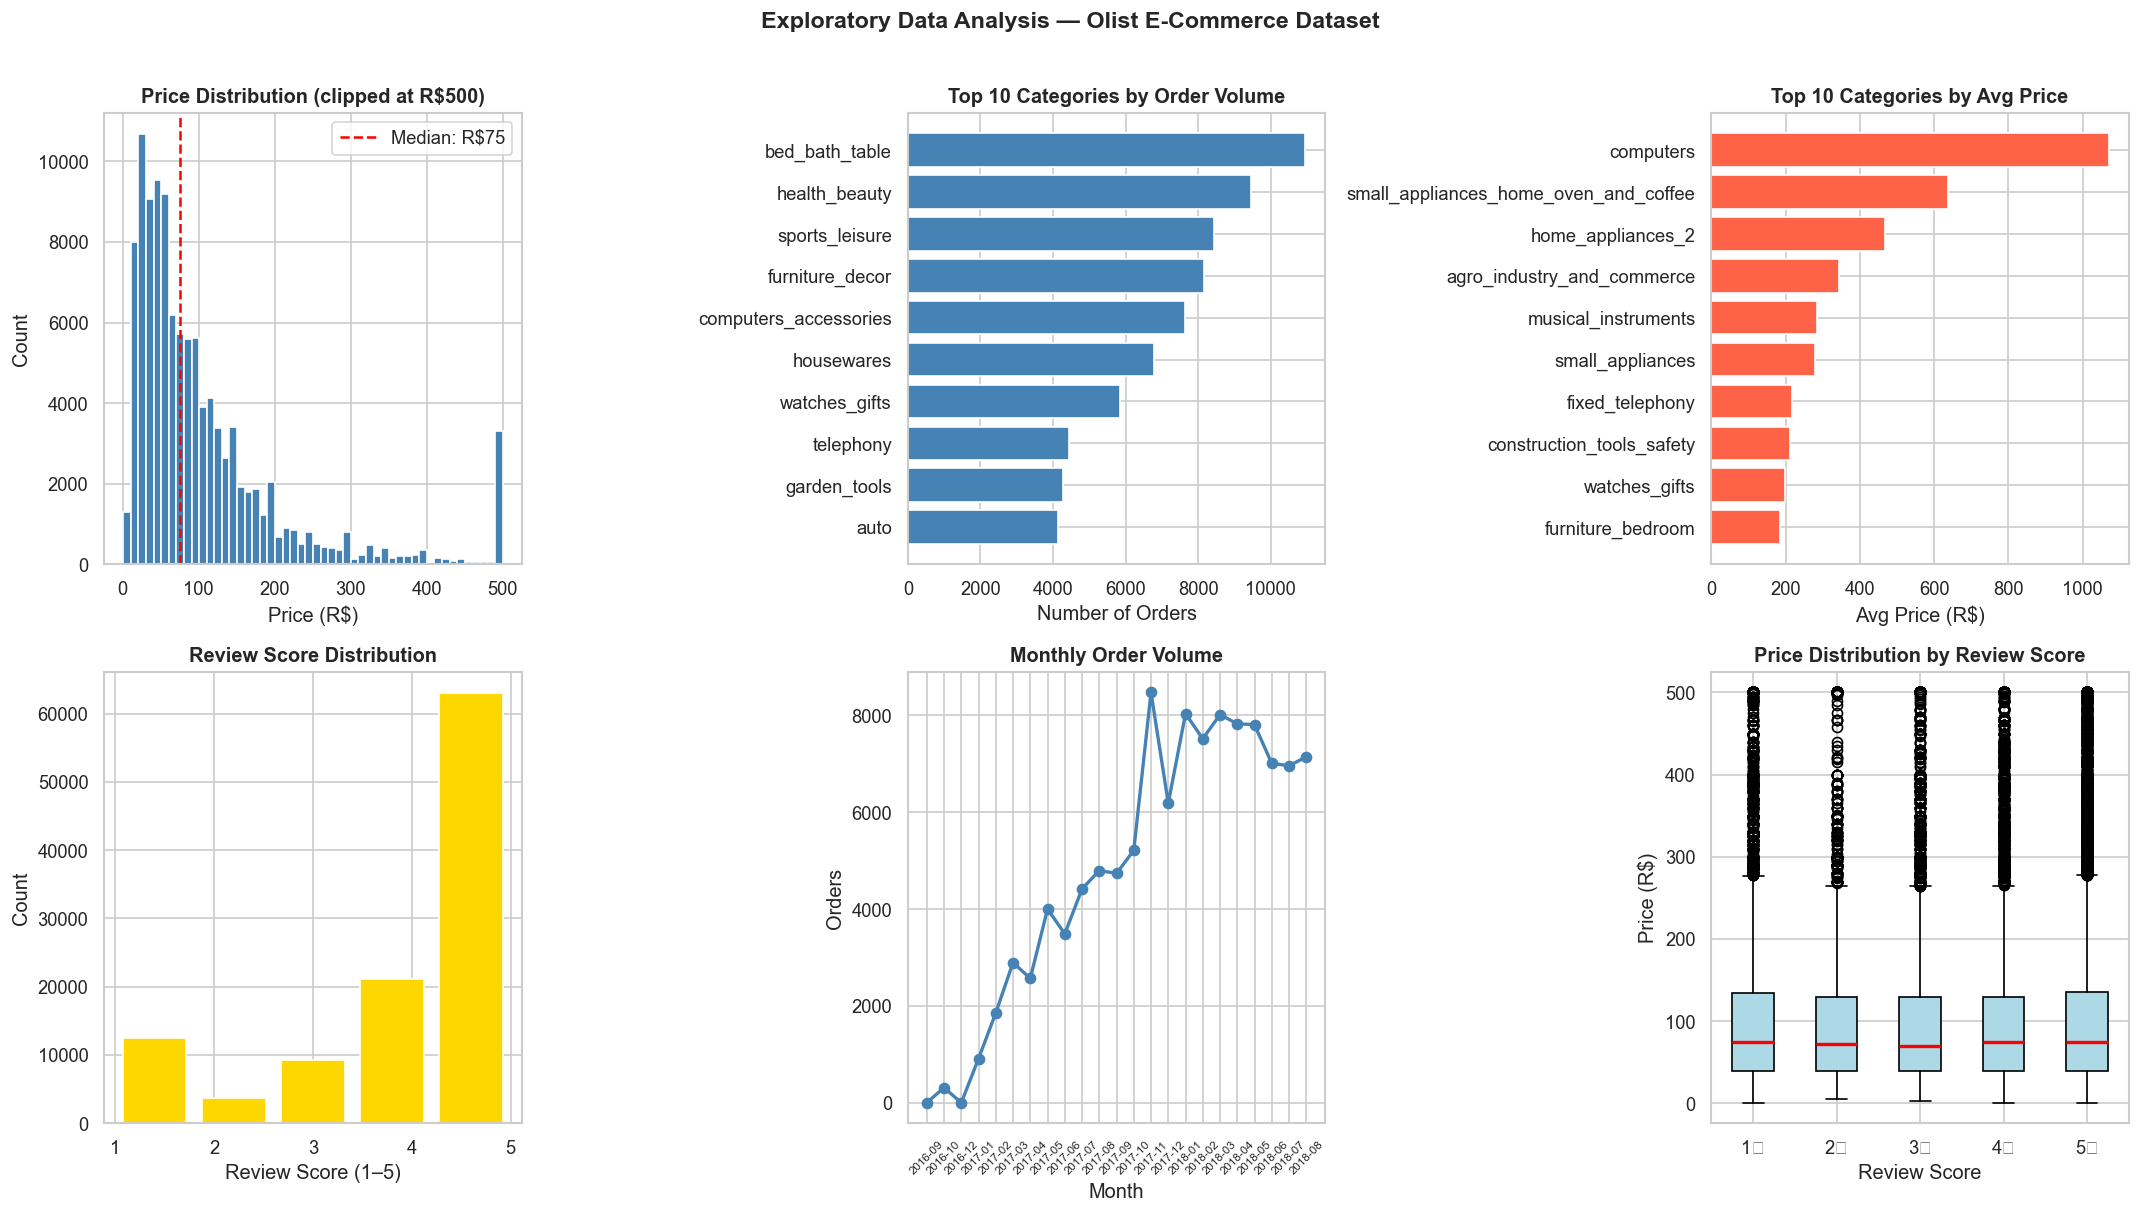

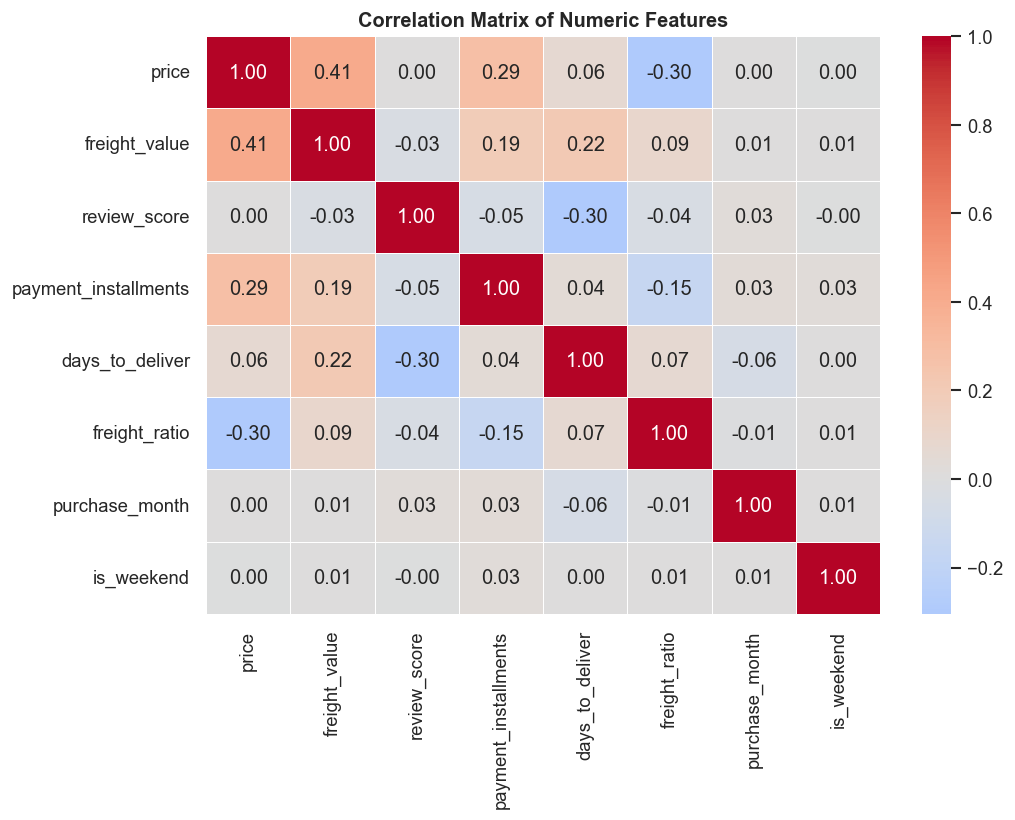

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Plot 1: Price Distribution ---
axes[0][0].hist(master["price"].clip(0, 500), bins=50, color="steelblue", edgecolor="white")
axes[0][0].set_title("Price Distribution (clipped at R$500)", fontweight="bold")
axes[0][0].set_xlabel("Price (R$)")
axes[0][0].set_ylabel("Count")
axes[0][0].axvline(master["price"].median(), color="red", linestyle="--",
                   label=f"Median: R${master['price'].median():.0f}")
axes[0][0].legend()

# --- Plot 2: Top 10 Categories by Order Volume ---
top_cats = master["category_en"].value_counts().head(10)
axes[0][1].barh(top_cats.index[::-1], top_cats.values[::-1], color="steelblue")
axes[0][1].set_title("Top 10 Categories by Order Volume", fontweight="bold")
axes[0][1].set_xlabel("Number of Orders")

# --- Plot 3: Avg Price per Top Category ---
cat_price = master.groupby("category_en")["price"].mean().nlargest(10)
axes[0][2].barh(cat_price.index[::-1], cat_price.values[::-1], color="tomato")
axes[0][2].set_title("Top 10 Categories by Avg Price", fontweight="bold")
axes[0][2].set_xlabel("Avg Price (R$)")

# --- Plot 4: Review Score Distribution ---
axes[1][0].hist(master["review_score"].dropna(), bins=5, color="gold", edgecolor="white",
                rwidth=0.8)
axes[1][0].set_title("Review Score Distribution", fontweight="bold")
axes[1][0].set_xlabel("Review Score (1–5)")
axes[1][0].set_ylabel("Count")

# --- Plot 5: Monthly Order Volume ---
monthly_vol = master.groupby(["purchase_year", "purchase_month"])["order_id"].count().reset_index()
monthly_vol["period"] = monthly_vol["purchase_year"].astype(str) + "-" + \
                         monthly_vol["purchase_month"].astype(str).str.zfill(2)
monthly_vol = monthly_vol.sort_values("period")
axes[1][1].plot(monthly_vol["period"], monthly_vol["order_id"], "o-", color="steelblue", linewidth=2)
axes[1][1].set_title("Monthly Order Volume", fontweight="bold")
axes[1][1].set_xlabel("Month")
axes[1][1].set_ylabel("Orders")
axes[1][1].tick_params(axis="x", rotation=45, labelsize=7)

# --- Plot 6: Price vs Review Score (box plot) ---
# Round review_score to nearest integer before comparison to handle float values
review_rounded = master["review_score"].round()
bucket_data = [master[review_rounded == s]["price"].clip(0, 500).dropna()
               for s in range(1, 6)]
axes[1][2].boxplot(bucket_data, labels=["1★", "2★", "3★", "4★", "5★"],
                   patch_artist=True,
                   boxprops=dict(facecolor="lightblue"),
                   medianprops=dict(color="red", linewidth=2))
axes[1][2].set_title("Price Distribution by Review Score", fontweight="bold")
axes[1][2].set_xlabel("Review Score")
axes[1][2].set_ylabel("Price (R$)")

plt.suptitle("Exploratory Data Analysis — Olist E-Commerce Dataset", fontsize=14,
             fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# Correlation matrix
num_cols = ["price", "freight_value", "review_score", "payment_installments",
            "days_to_deliver", "freight_ratio", "purchase_month", "is_weekend"]
corr = master[num_cols].dropna().corr()

fig2, ax2 = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, ax=ax2)
ax2.set_title("Correlation Matrix of Numeric Features", fontweight="bold")
plt.tight_layout()
plt.show()


## Step 4: Feature Engineering

We encode the categorical `category_en` feature and select a concise set of input features to predict `price`.

| Feature | Description |
|---|---|
| `freight_value` | Shipping cost |
| `review_score` | Customer rating (1–5) |
| `payment_installments` | Number of payment instalments |
| `days_to_deliver` | Actual delivery time in days |
| `purchase_month` | Month of purchase (1–12) |
| `is_weekend` | 1 if ordered on Sat/Sun |
| `category_encoded` | Label-encoded product category |

In [12]:
from sklearn.preprocessing import LabelEncoder

# ── Encode product category ──────────────────────────────────────────────────
le = LabelEncoder()
master["category_encoded"] = le.fit_transform(master["category_en"].fillna("unknown"))

# ── Select features and target ───────────────────────────────────────────────
FEATURES = ["freight_value", "review_score", "payment_installments",
            "days_to_deliver", "purchase_month", "is_weekend", "category_encoded"]
TARGET = "price"

df_model = master[FEATURES + [TARGET]].dropna()
print(f"Modelling dataset: {len(df_model):,} rows  |  {len(FEATURES)} features")

X = df_model[FEATURES]
y = df_model[TARGET]

# ── Train / test split (80 / 20) ─────────────────────────────────────────────
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print(f"Train size : {len(X_train):,}   |   Test size : {len(X_test):,}")

# ── Helper: evaluation metrics ───────────────────────────────────────────────
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

def evaluate(model_name, y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{model_name:30s}  RMSE={rmse:.2f}   MAE={mae:.2f}   R²={r2:.4f}")
    return {"model": model_name, "RMSE": rmse, "MAE": mae, "R²": r2}

results = []   # collect both models here

Modelling dataset: 109,357 rows  |  7 features
Train size : 87,485   |   Test size : 21,872


## Step 5: Algorithm 1 — Linear Regression

**Linear Regression** models the target as a weighted sum of input features:

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$$

It is interpretable and acts as our **baseline** model.

Linear Regression               RMSE=162.77   MAE=77.02   R²=0.2107

Feature Coefficients (sorted by |value|):
             Feature  Coefficient
payment_installments    14.165897
          is_weekend    -4.247126
       freight_value     4.187703
        review_score     2.353111
      purchase_month    -0.558170
     days_to_deliver    -0.408842
    category_encoded     0.140031


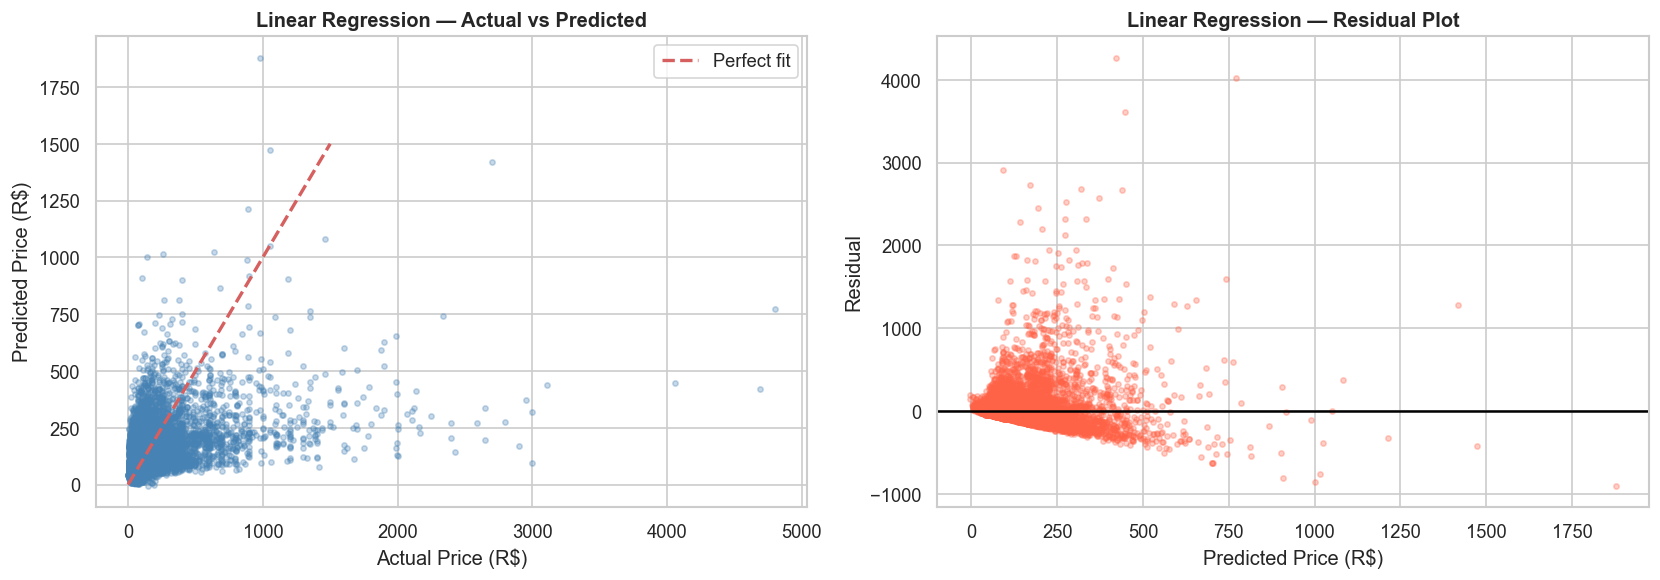

In [13]:
from sklearn.linear_model import LinearRegression

# ── Train ────────────────────────────────────────────────────────────────────
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# ── Predict & evaluate ───────────────────────────────────────────────────────
lr_pred = lr_model.predict(X_test)
lr_metrics = evaluate("Linear Regression", y_test, lr_pred)
results.append(lr_metrics)

# ── Coefficient table ─────────────────────────────────────────────────────────
coef_df = pd.DataFrame({"Feature": FEATURES, "Coefficient": lr_model.coef_})
coef_df = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)
print("\nFeature Coefficients (sorted by |value|):")
print(coef_df.to_string(index=False))

# ── Plots ─────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, lr_pred, alpha=0.3, s=10, color="steelblue")
lims = [0, min(y_test.max(), lr_pred.max(), 1500)]
axes[0].plot(lims, lims, "r--", linewidth=2, label="Perfect fit")
axes[0].set_xlabel("Actual Price (R$)")
axes[0].set_ylabel("Predicted Price (R$)")
axes[0].set_title("Linear Regression — Actual vs Predicted", fontweight="bold")
axes[0].legend()

# Residuals
residuals = y_test - lr_pred
axes[1].scatter(lr_pred, residuals, alpha=0.3, s=10, color="tomato")
axes[1].axhline(0, color="black", linewidth=1.5)
axes[1].set_xlabel("Predicted Price (R$)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Linear Regression — Residual Plot", fontweight="bold")

plt.tight_layout()
plt.show()

## Step 6: Algorithm 2 — Decision Tree Regressor

A **Decision Tree** recursively splits the feature space into regions and predicts the mean target value in each leaf. It can capture **non-linear** pricing patterns that Linear Regression misses.

We limit `max_depth=5` to avoid overfitting.

Decision Tree (max_depth=5)     RMSE=161.59   MAE=75.27   R²=0.2221

Feature Importances:
             Feature  Importance
       freight_value    0.671215
payment_installments    0.231014
    category_encoded    0.074398
     days_to_deliver    0.023374
        review_score    0.000000
      purchase_month    0.000000
          is_weekend    0.000000


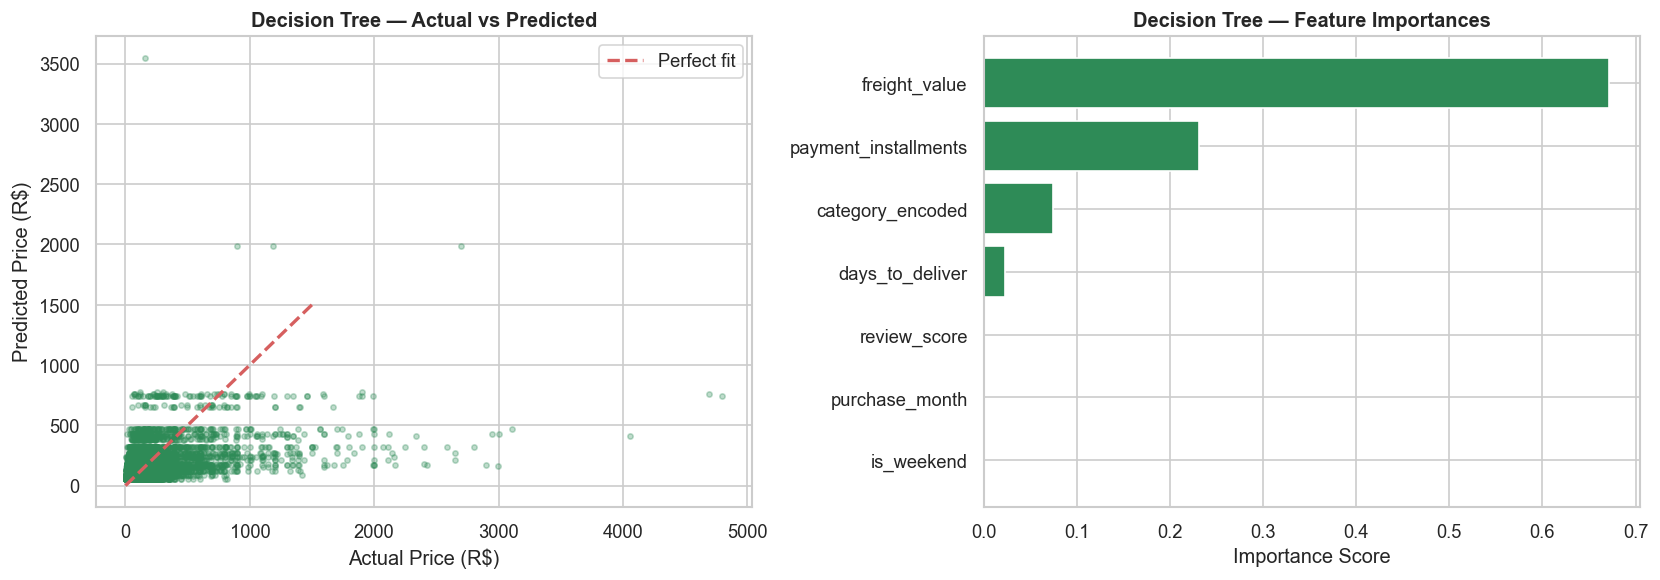

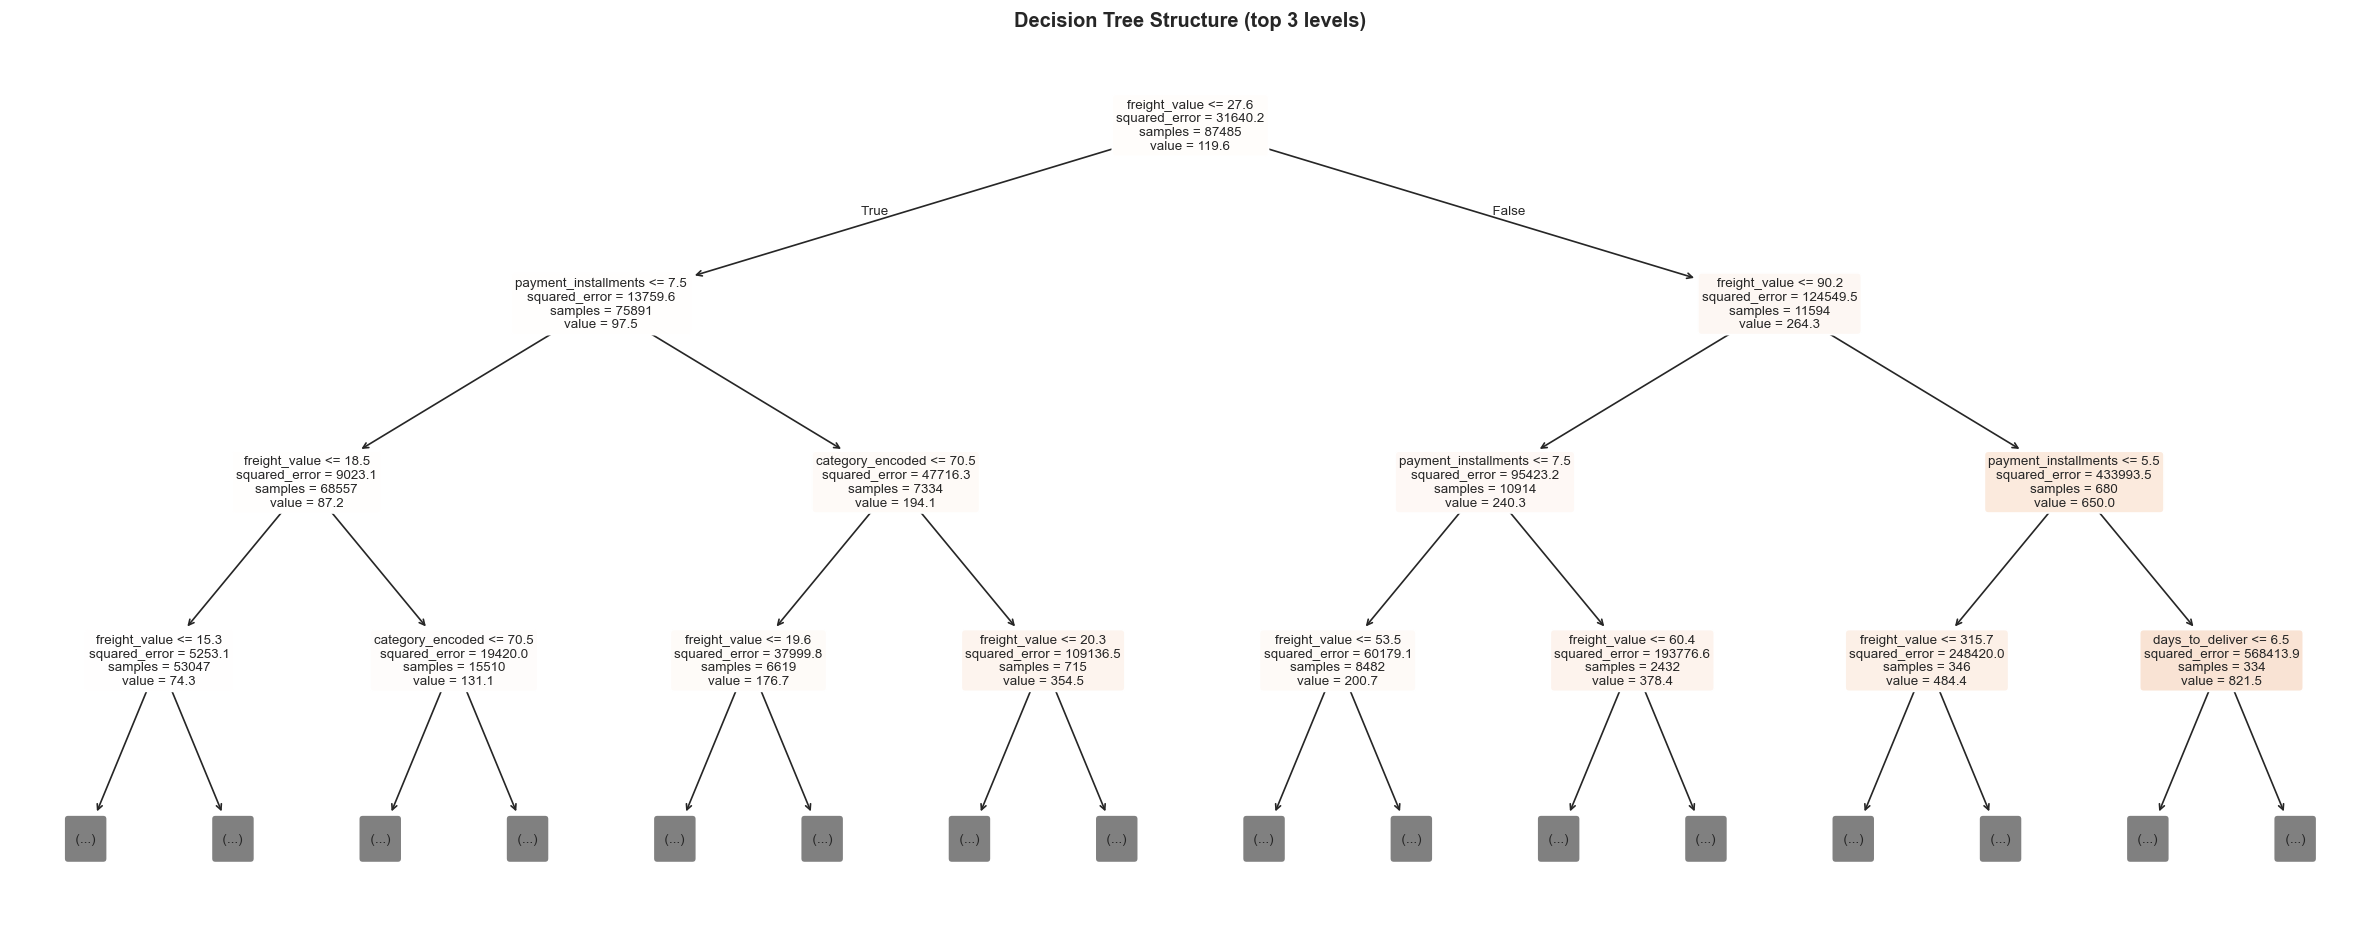

In [14]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# ── Train ────────────────────────────────────────────────────────────────────
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# ── Predict & evaluate ───────────────────────────────────────────────────────
dt_pred = dt_model.predict(X_test)
dt_metrics = evaluate("Decision Tree (max_depth=5)", y_test, dt_pred)
results.append(dt_metrics)

# ── Feature importance ────────────────────────────────────────────────────────
imp_df = pd.DataFrame({"Feature": FEATURES, "Importance": dt_model.feature_importances_})
imp_df = imp_df.sort_values("Importance", ascending=False)
print("\nFeature Importances:")
print(imp_df.to_string(index=False))

# ── Plots ─────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, dt_pred, alpha=0.3, s=10, color="seagreen")
lims = [0, min(y_test.max(), dt_pred.max(), 1500)]
axes[0].plot(lims, lims, "r--", linewidth=2, label="Perfect fit")
axes[0].set_xlabel("Actual Price (R$)")
axes[0].set_ylabel("Predicted Price (R$)")
axes[0].set_title("Decision Tree — Actual vs Predicted", fontweight="bold")
axes[0].legend()

# Feature Importance bar chart
axes[1].barh(imp_df["Feature"][::-1], imp_df["Importance"][::-1], color="seagreen")
axes[1].set_xlabel("Importance Score")
axes[1].set_title("Decision Tree — Feature Importances", fontweight="bold")

plt.tight_layout()
plt.show()

# ── Tree structure visualisation (depth 3 for readability) ────────────────────
fig3, ax3 = plt.subplots(figsize=(20, 8))
plot_tree(dt_model, max_depth=3, feature_names=FEATURES, filled=True,
          fontsize=8, rounded=True, precision=1, ax=ax3)
ax3.set_title("Decision Tree Structure (top 3 levels)", fontweight="bold", fontsize=12)
plt.tight_layout()
plt.show()

## Step 7: Model Comparison & Conclusion

We compare both models on the same held-out test set using three metrics:

| Metric | Meaning | Lower/Higher is better |
|---|---|---|
| **RMSE** | Root Mean Squared Error — penalises large errors | **Lower** |
| **MAE** | Mean Absolute Error — average absolute deviation | **Lower** |
| **R²** | Explained variance (0–1 scale) | **Higher** |

          MODEL COMPARISON SUMMARY
                                   RMSE        MAE        R²
model                                                       
Linear Regression            162.766315  77.018637  0.210677
Decision Tree (max_depth=5)  161.585054  75.272604  0.222093

Best model by RMSE: Decision Tree (max_depth=5)
RMSE improvement  : 0.7%


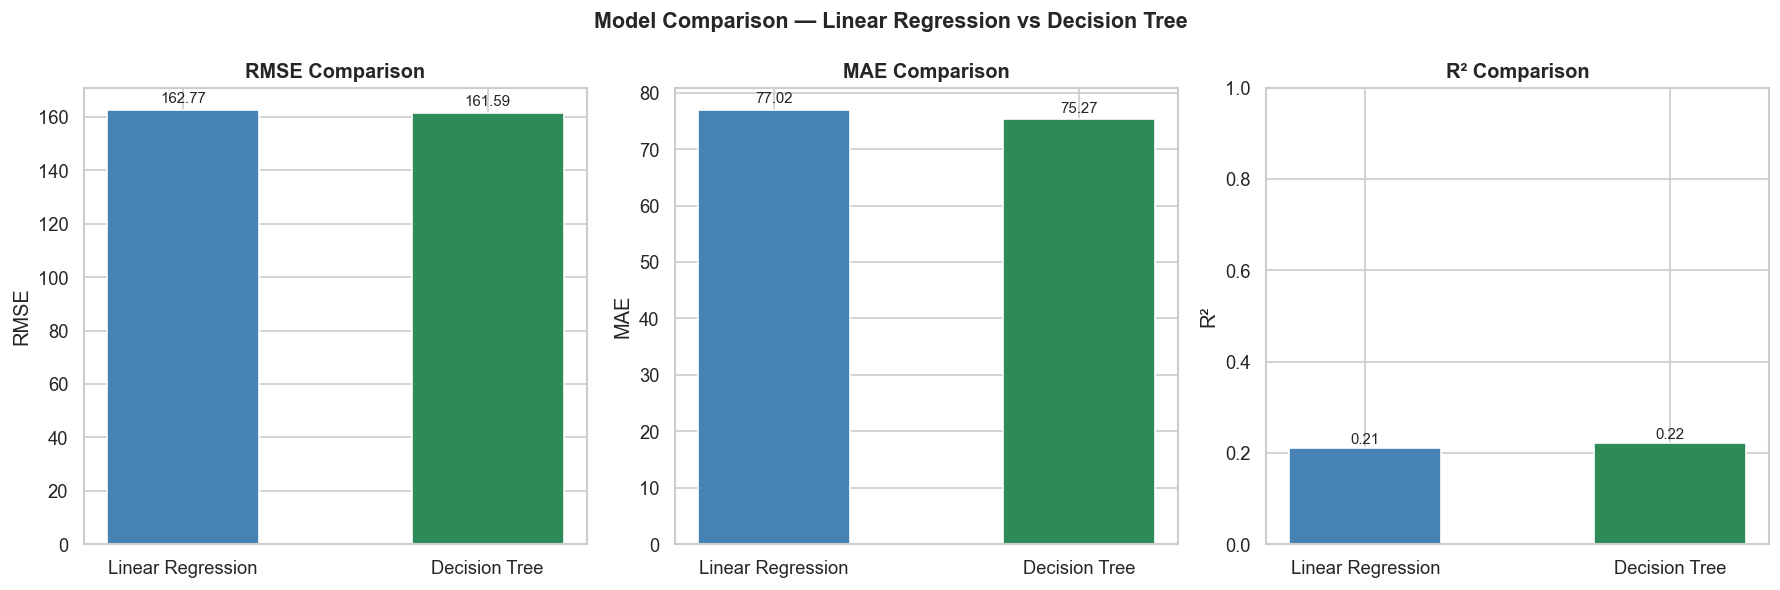

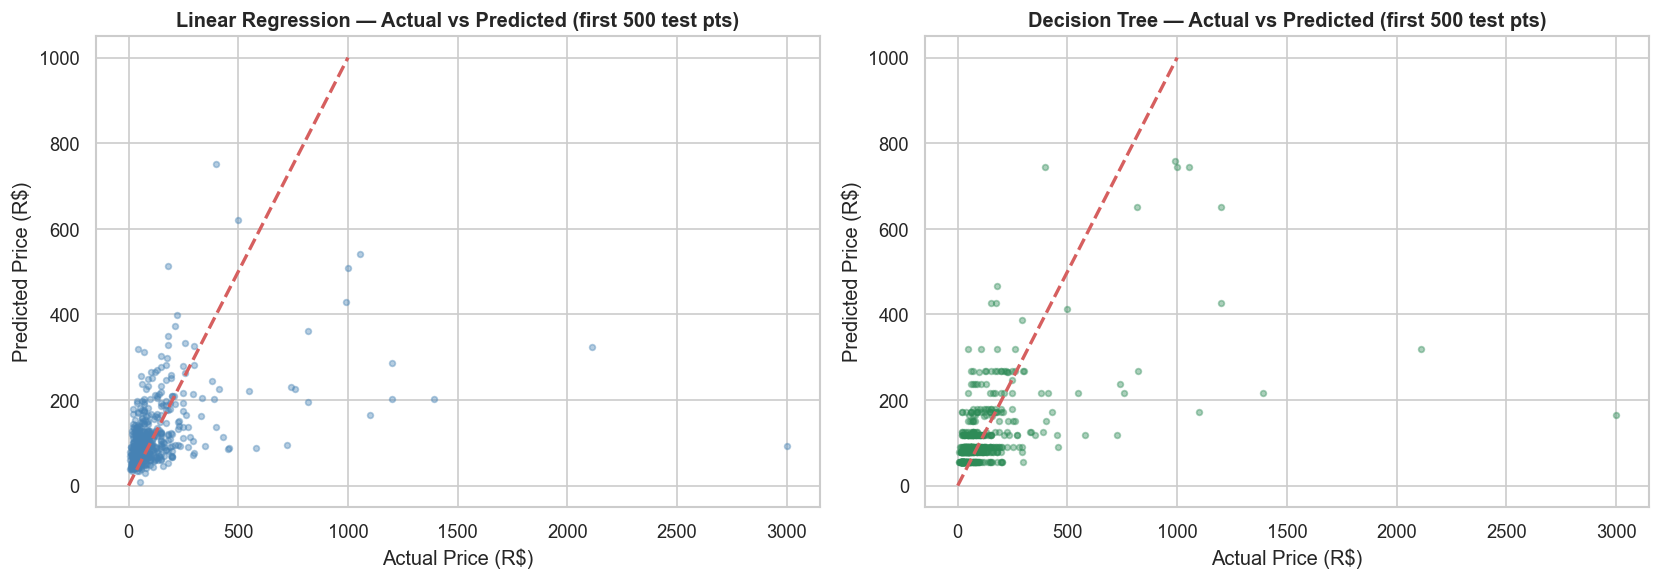


✅ Review 1 notebook complete.
   Two baseline algorithms trained, evaluated, and compared.


In [15]:
import warnings
warnings.filterwarnings("ignore")

# ── Summary table ─────────────────────────────────────────────────────────────
results_df = pd.DataFrame(results).set_index("model")
print("=" * 55)
print("          MODEL COMPARISON SUMMARY")
print("=" * 55)
print(results_df.to_string())
print("=" * 55)

winner = results_df["RMSE"].idxmin()
improvement = (results_df.loc[results_df["RMSE"].idxmax(), "RMSE"] -
               results_df["RMSE"].min()) / results_df["RMSE"].max() * 100
print(f"\nBest model by RMSE: {winner}")
print(f"RMSE improvement  : {improvement:.1f}%")

# ── Bar chart: RMSE and MAE ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ["RMSE", "MAE", "R²"]
colors = ["steelblue", "seagreen"]
model_labels = [r.replace(" (max_depth=5)", "") for r in results_df.index]

for i, metric in enumerate(metrics_to_plot):
    vals = results_df[metric].values
    bars = axes[i].bar(model_labels, vals, color=colors, edgecolor="white", width=0.5)
    axes[i].set_title(f"{metric} Comparison", fontweight="bold")
    axes[i].set_ylabel(metric)
    for bar, v in zip(bars, vals):
        axes[i].text(bar.get_x() + bar.get_width() / 2,
                     bar.get_height() + 0.01 * abs(v),
                     f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    if metric == "R²":
        axes[i].set_ylim(0, 1)

plt.suptitle("Model Comparison — Linear Regression vs Decision Tree",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# ── Side-by-side Actual vs Predicted ─────────────────────────────────────────
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
plot_data = [("Linear Regression", lr_pred, "steelblue"),
             ("Decision Tree",     dt_pred,  "seagreen")]

for ax, (name, pred, col) in zip(axes2, plot_data):
    ax.scatter(y_test.values[:500], pred[:500], alpha=0.4, s=12, color=col, label=name)
    lim = min(float(y_test.max()), float(pred.max()), 1000)
    ax.plot([0, lim], [0, lim], "r--", linewidth=2)
    ax.set_xlabel("Actual Price (R$)")
    ax.set_ylabel("Predicted Price (R$)")
    ax.set_title(f"{name} — Actual vs Predicted (first 500 test pts)", fontweight="bold")

plt.tight_layout()
plt.show()

print("\n✅ Review 1 notebook complete.")
print("   Two baseline algorithms trained, evaluated, and compared.")